# 테스트 데이터 로딩 및 평가

## 필요 라이브러리 임포트

In [ ]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------
import numpy as np
import librosa
import os

## 데이터 로딩 함수 정의

In [3]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=170):
    X_list, y_list = [], [] # X_list: 입력 데이터 (feature vectors) / y_list: 정답 레이블 (target labels)
    with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    filename = parts[1]
                    label = parts[-1]
                    fp = os.path.join(audio_path, filename)
                    if not os.path.isfile(fp):
                        continue
                    try:
                        audio, sr = librosa.load(fp, sr=16000)
                        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T
                        # 발화의 평균길이를 제한. 3~5초 기준으로 200의 길이가 넘을 경우, 자르고 넘지 않을 경우 padding을 넣어 통일.
                        if mfcc.shape[0] < max_len:
                            mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)), mode='constant')
                        else:
                            mfcc = mfcc[:max_len]
                        X_list.append(mfcc)
                        y_list.append(0 if label == 'Real' else 1) # Real은 0 / False 는 1
                    except:
                        continue

    return np.array(X_list), np.array(y_list)
from sklearn.preprocessing import StandardScaler
def standardize(X):
    ns, nt, nf = X.shape
    # ns = 샘플 수 (num_samples)
    # nt = 시간 프레임 수 (max_len 등)
    # nf = MFCC feature 차원 수 (예: 20)
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler

## Test DataSet 파일 경로 선언 및 데이터셋 로딩

In [4]:
test_audio_path = '2501ml_data/test'
test_label_path = '2501ml_data/label/test_label.txt'

In [ ]:
# 음성 프레임 200으로 설정(약 3~5초 음성 파일 기준 고려.)
max_len = 200
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)

ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

In [6]:
print("테스트 데이터의 개수:", len(X_test))
print("테스트 데이터 X의 shape:", X_test[0].shape)

테스트 데이터의 개수: 2000
테스트 데이터 X의 shape: (200, 20)


## 모델 로딩

In [7]:
from tensorflow.keras.models import load_model

model = load_model("dnn_model.h5")

## 테스트 데이터 평가 (Spectral contrast 특징 활용 전)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.85      1.00      0.92      1000
        Fake       1.00      0.83      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.93      0.91      0.91      2000
weighted avg       0.93      0.91      0.91      2000

ROC AUC: 0.920


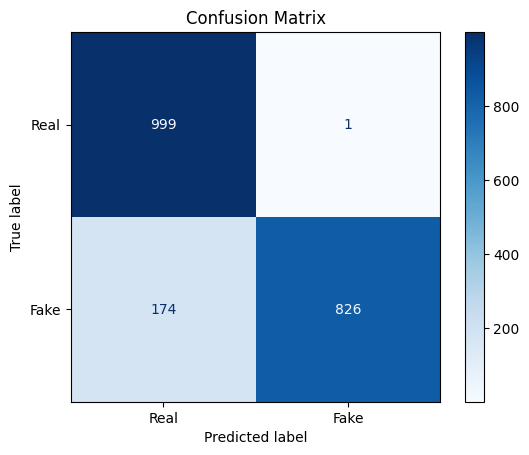

In [8]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 예측
y_prob = model.predict(X_test)
y_pred_classes = (y_prob > 0.5).astype(int)

# 리포트 출력
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred_classes, target_names=['Real', 'Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Spectral_Contrast 특징 활용
- 오분류된 데이터에 대해서 따로 특징을 추출하여 분류를 시도함. 이를 활용하여 약 1% 성능 향상이 가능하였음.

### Spectral Contrast 활용 예측 메소드 선언
- 다음 메소드를 통해, 모델과 Spectral contrast를 활용한 분류를 수행한다. 

In [9]:
# 애매모호한 특징에 대해서 선별하고 Spectral Contrast 값을 기준으로, class를 재 분류하는 메소드.
def predict_with_spectral_contrast(model,X_test,score:float = 0.32):
    # 🔹 1. DNN 예측
    y_prob = model.predict(X_test).flatten()

    # 🔹 2. 보정 대상: 확률이 낮은 샘플
    uncertain_idx = np.where(y_prob < score)[0]

    # 🔹 3. test_label.txt에서 파일 이름과 라벨 수동 파싱
    test_filenames = []

    with open(test_label_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                test_filenames.append(parts[1])
    

    # 🔹 4. Spectral contrast 기반 보정
    for idx in uncertain_idx:
        filename = test_filenames[idx]
        file_path = os.path.join(test_audio_path, filename)

        try:
            y, sr = librosa.load(file_path, sr=16000)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr) # 해당 특징은 각 주파수 대역별 최댓값과 최솟값의 차이를 기반으로 스펙트럼의 뚜렷함(sharpness)을 측정.
            high_contrast = np.mean(contrast[-2:, :])  # 고주파 2대역 평균
            # 실험한 결과, 가장 적합한 기준 값으로 선정함. (선정 과정 결과 코드 생략)
            if (high_contrast < 21.0 or high_contrast > 27.0):
                y_prob[idx] = 1.0  # Fake로 강제 보정
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return y_prob

### Test data 평가

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.87      1.00      0.93      1000
        Fake       1.00      0.85      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000

ROC AUC: 0.929


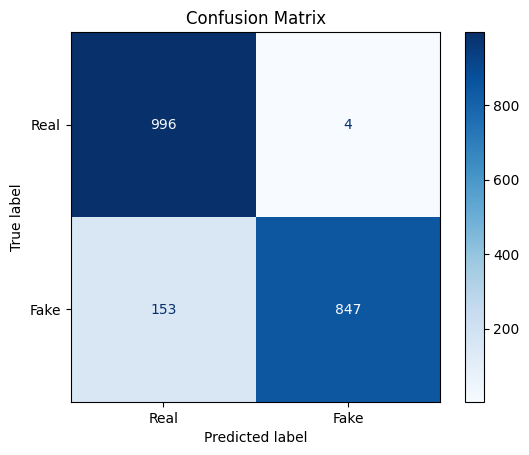

In [10]:
# 🔹 5. 최종 이진 판정 (확률 기준은 0.5 유지)
y_prob = predict_with_spectral_contrast(model,X_test, score=0.5)
y_pred = (y_prob >= 0.5).astype(int)

# 리포트 출력
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 예측 결과 파일 작성

In [11]:

from sklearn.preprocessing import LabelEncoder
# 1. test 파일명 리스트 로딩(결과 파일을 만들기 위해 따로 filenames만 추출하는 메소드 선언)
def get_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob =predict_with_spectral_contrast(model,X_test,score=0.5 )
y_pred_classes = (y_pred_prob <= 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./Deepwave_test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ Deepwave_test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
✅ Deepwave_test_result.txt 저장 완료 (Perl 평가용)


In [1]:
!perl 2501ml_data/eval.pl Deepwave_test_result.txt 2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: Deepwave_test_result.txt
True: 2501ml_data/label/test_label.txt
Accuracy: 92.15%
Hit: 1843, Total: 2000
